# ELE510 Image Processing with robot vision: LAB, Exercise 6, Image features detection.

**Purpose:** *To learn about the edges and corners features detection, and their descriptors.*

The theory for this exercise can be found in chapter 7 of the text book [1] and in appendix C in the compendium [2]. See also the following documentations for help:
- [OpenCV](https://opencv.org/opencv-python-free-course/)
- [numpy](https://numpy.org/doc/stable/)
- [matplotlib](https://matplotlib.org/stable/contents.html)
- [scipy](https://docs.scipy.org/doc/)


**IMPORTANT:** Read the text carefully before starting the work. In
many cases it is necessary to do some preparations before you start the work
on the computer. Read necessary theory and answer the theoretical part
first. The theoretical and experimental part should be solved individually.
The notebook must be approved by the lecturer or his assistant.

**Approval:**
<div class="alert alert-block alert-success">
The current notebook should be submitted on CANVAS as a single pdf file. 
</div>

<div class="alert alert-block alert-info">
    To export the notebook in a pdf format, goes to File -> Download as -> PDF via LaTeX (.pdf).
</div>

**Note regarding the notebook**: The theoretical questions can be answered directly on the notebook using a *Markdown* cell and LaTex commands (if relevant). In alternative, you can attach a scan (or an image) of the answer directly in the cell.

Possible ways to insert an image in the markdown cell:

`![image name]("image_path")`

`<img src="image_path" alt="Alt text" title="Title text" />`


**Under you will find parts of the solution that is already programmed.**

<div class="alert alert-block alert-info">
    <p>You have to fill out code everywhere it is indicated with `...`</p>
    <p>The code section under `######## a)` is answering subproblem a) etc.</p>
</div>

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides good and reliable detection.

**a)** Create the **Canny algorithm**, described at pag. 336 (alg. 7.1). For the last step (`EDGELINKING`) you can either use the algorithm 7.3 at page 338 or the `HYSTERESIS THRESHOLD` algorithm 10.3 described at page 451.
All the following images are taken from the text book [1].

![canny.png](images/canny.png)

![nonmaxsuppression.png](images/nonmaxsuppression.png)

![edgelinking.png](images/edgelinking.png)

**Remember:**

- Sigma (second parameter in the Canny algorithm) is not necessary for the calculation since the Sobel operator (in opencv) combines the Gaussian smoothing and differentiation, so the results is nore or less resistant to the noise. 
- We are defining the low and high thresholds manually in order to have a better comparison with the predefined opencv function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

### P.S. : 
<div class="alert alert-block alert-info">
The goal of this problem it is not to create a **perfect** replication of the algorithm in opencv, but to understand the various steps involved and to be able to extract the edges from an ima ge using these steps.
</div>

In [1]:
# Sobel operator to find the first derivate in the horizontal and vertical directions
def computeImageGradient(Im, ksize=9):
    # Sobel operator  to find the first derivate in the horizontal and vertical directions
    
    ## TODO: The default ksize is 3, try different values and comment the result 
    g_x = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    g_y = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
    
    ############################
    # Calculate the magnitude and the gradient direction like it is performed during the assignment 4 (problem 2a)
    kernelx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

    I_x = cv2.filter2D(Im, -1, kernelx)
    I_y = cv2.filter2D(Im, -1, kernely)
    
    # Calculate the gradient direction in degrees
    G_mag =  np.around(np.hypot(I_x, I_y), 2).astype(int)
    G_phase = (180/np.pi) * np.arctan2(I_x.flatten(), I_y.flatten())
    G_phase = G_phase.reshape(G_mag.shape).astype(int)
    return G_mag, G_phase

In [2]:
# NonMaxSuppression algorithm 
def nonMaxSuppression(G_mag, G_phase):
    G_localmax = np.zeros((G_mag.shape))
    pi_t = np.pi / 8 #  pi threshold
        
    # For each pixel, adjust the phase to ensure that -pi/8 <= theta < 7*pi/8
    for x in range(G_localmax.shape[0]):
        neighx_sub = 0 if x - 1 < 0 else x-1
        neighx_sup = x if x + 1 >= G_localmax.shape[0] else x + 1
        for y in range(G_localmax.shape[1]):
            neighy_sub = 0 if y - 1 < 0 else x-1
            neighy_sup = y if y + 1 >= G_localmax.shape[1] else y + 1
            theta = G_phase[x][y]
            v = G_mag[x][y]
            neigh1 = -1
            neigh2 = -1
            
            if theta >= pi_t * 7:
                theta = theta - np.pi
            if theta < -pi_t:
                theta = theta + np.pi
            if theta >= -pi_t  and theta < pi_t:
                neigh1 = G_mag[neighx_sub , y]
                neigh2 = G_mag[neighx_sup , y]
            elif theta >= pi_t and theta < pi_t * 3:
                neigh1 = G_mag[neighx_sub , neighy_sub]
                neigh2 = G_mag[neighx_sup , neighy_sup]
            elif theta >= pi_t * 3 and theta < pi_t * 5:
                neigh1 = G_mag[x , neighy_sub]
                neigh2 = G_mag[x , neighy_sup]
            elif theta >= pi_t * 5 and theta < pi_t * 7:
                neigh1 = G_mag[neighx_sub , neighy_sup]
                neigh2 = G_mag[neighx_sup , neighy_sub]
            if v >= neigh1 and v >= neigh2:
                G_localmax[x,y] = v
            else:
                G_localmax[x,y] = 0
    return G_localmax

In [3]:
def edgeLinking(G_localmax, t_low, t_high):
    I_edges = np.zeros((G_localmax.shape))
    frontier = []
    ON = 255
    # Set the threshold image and perform edge linking (or hysteresis thresholding)
    for x in range(G_localmax.shape[0]):
        for y in range(G_localmax.shape[1]):
            v = G_localmax[x, y]
            if v > t_high:
                frontier.insert(0,(x,y))
                I_edges[x,y] = ON
    while len(frontier) > 0:
        p = frontier.pop()
        for x in range(p[0]-1, p[0] + 1):
            if x < 0 or x >= I_edges.shape[0]:
                continue
            for y in range(p[1] - 1, p[1] + 1):
                if y < 0 or y >= I_edges.shape[1]:
                    continue
                if G_localmax[x, y] > t_low:
                    if I_edges[x,y]== 0:    
                        frontier.insert(0,(x,y))
                        I_edges[x,y]= ON    
    return I_edges

In [4]:
"""
Function that performs the Canny algorithm.

The entire cell is locked, thus you can only test the function and NOT change it!

Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking
    if t_low>t_high: t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)
    
    plt.figure(figsize=(30,30))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray')
    plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray')
    plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray')
    plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray')
    plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

In [5]:
import os
images = os.listdir('images')
images

['arrow_1.jpg',
 'arrow_2.jpg',
 'arrow_3.jpg',
 'cameraman.jpg',
 'canny.png',
 'chessboard.png',
 'edgelinking.png',
 'nonmaxsuppression.png']

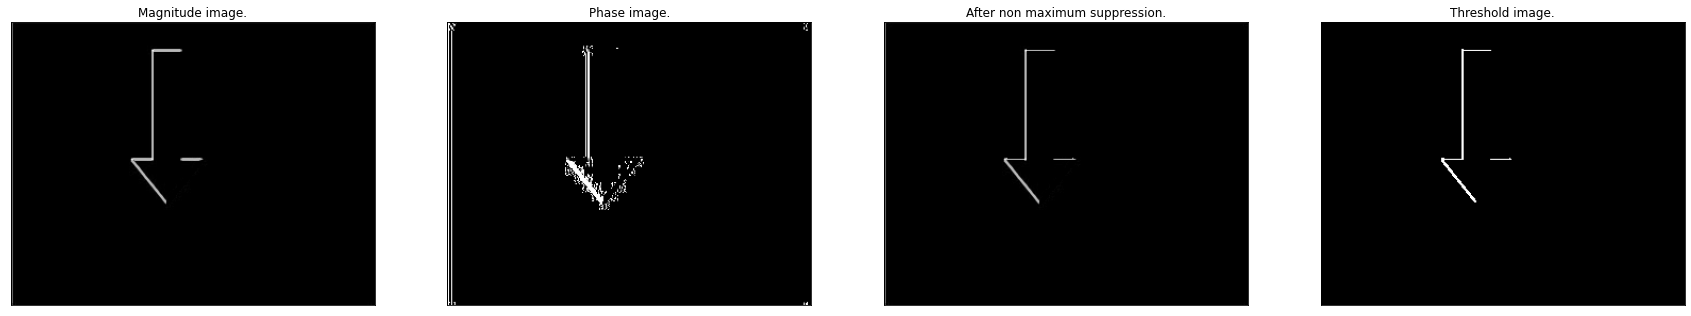

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Im = cv2.imread('images/arrow_1.jpg', cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)


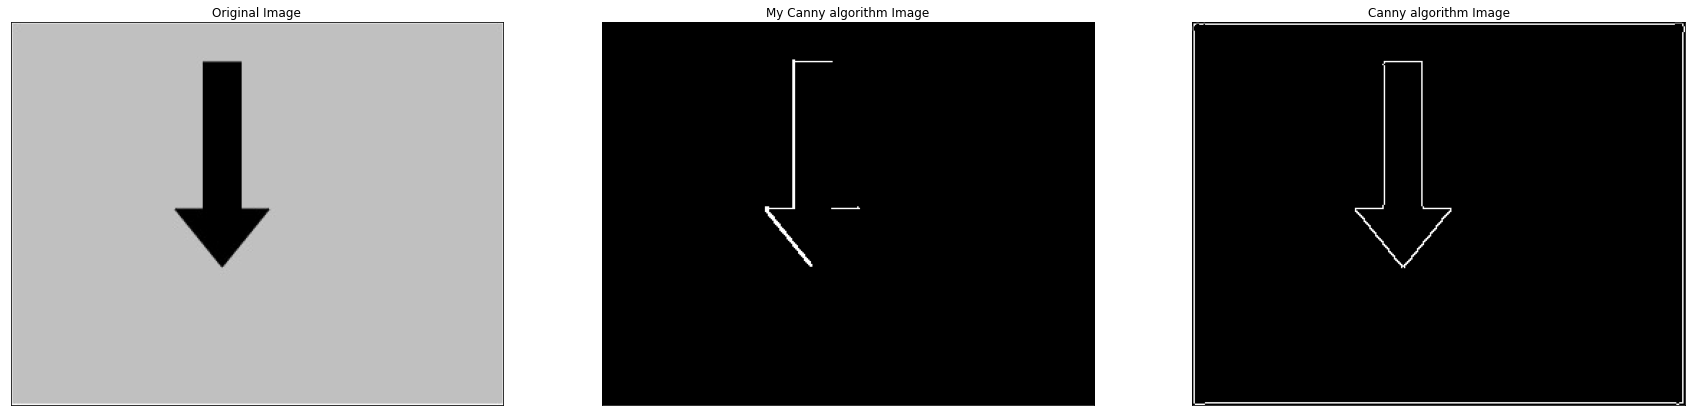

In [7]:
# LOCKED cell: useful to check and visualize the results.

plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(Im, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray')
plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.Canny(Im,t_low, t_high, L2gradient=False), cmap='gray')
plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=3, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS).

**b)** Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/trunk/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

**c)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

**d)** What happen if you change (increase/decrease) the `k` constant for the "corner points"? 


In [104]:
# Answers go here
def process_markers(im,k=0.04):
    Im_gray = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
    Im_color = cv2.imread(im)
    Im_ch = cv2.cornerHarris(Im_gray, blockSize=3, ksize=3, k=k)
    Im_ch = cv2.dilate(Im_ch,None)
    Im_ch[Im_ch > 0.001*Im_ch .max()]=255
    for x in range( Im_ch.shape[0] ):
        for y in range( Im_ch.shape[1] ):
            if Im_ch[x,y] == 255:
                cv2.drawMarker(Im_color, position=(y,x),color=(255,100,0),markerType=cv2.MARKER_CROSS)
    plt.figure(figsize=(30,30))
    plt.subplot(131), plt.imshow(Im_gray, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(Im_ch, cmap='gray')
    plt.title(f'Corner Harris k = {k}'), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(Im_color)
    plt.title(f'Image with corners marked k = {k}'), plt.xticks([]), plt.yticks([])
    plt.show()

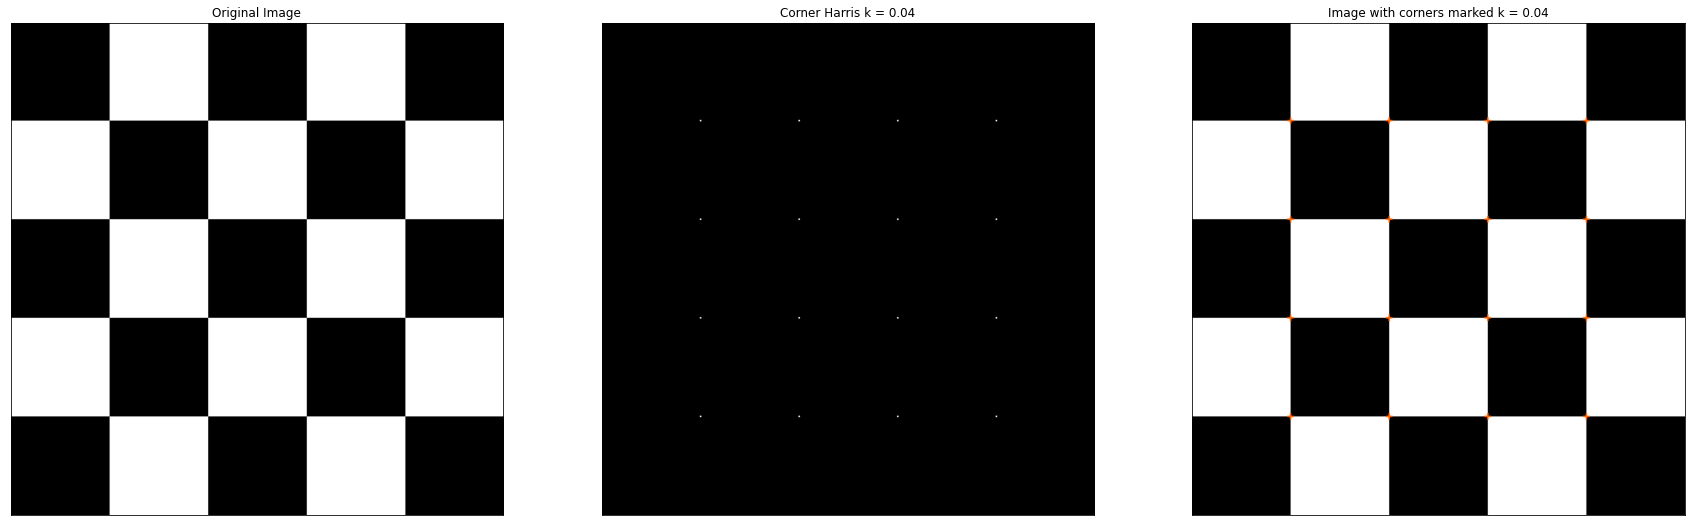

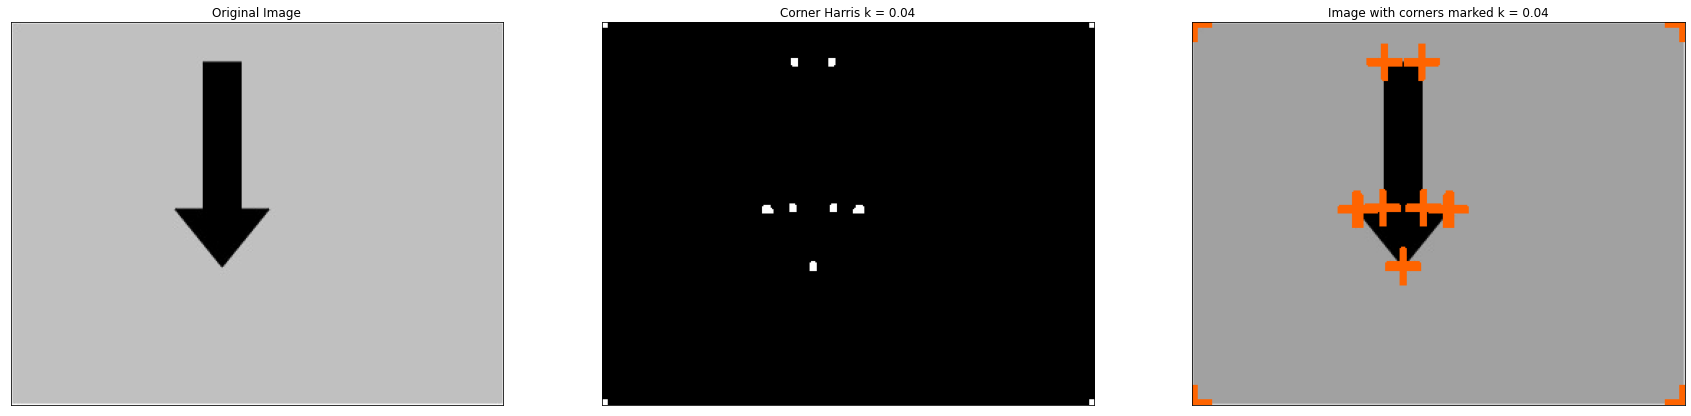

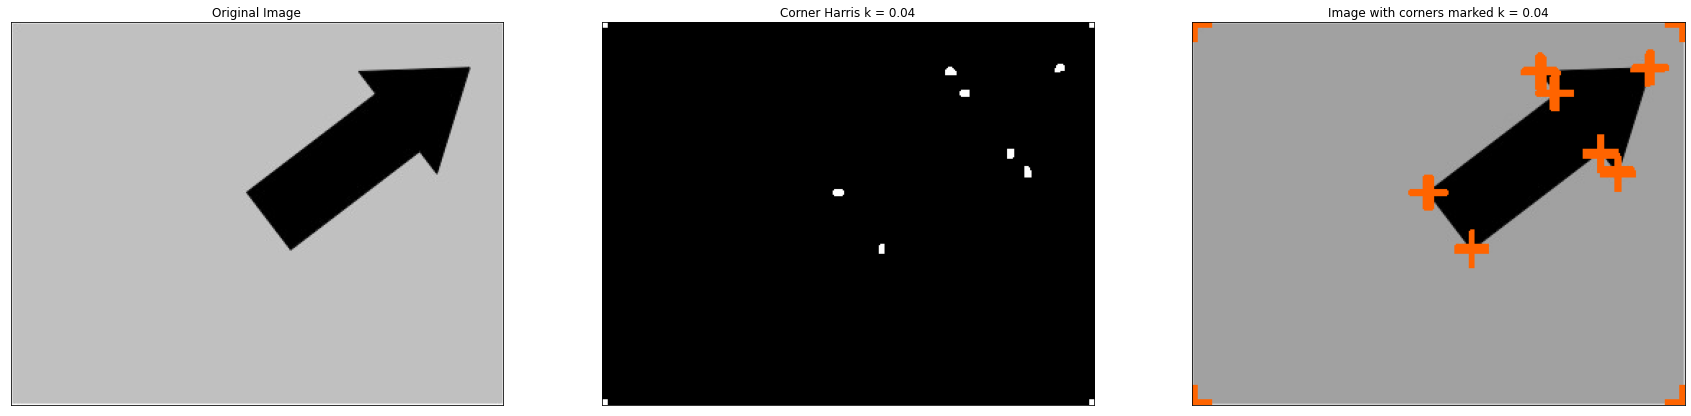

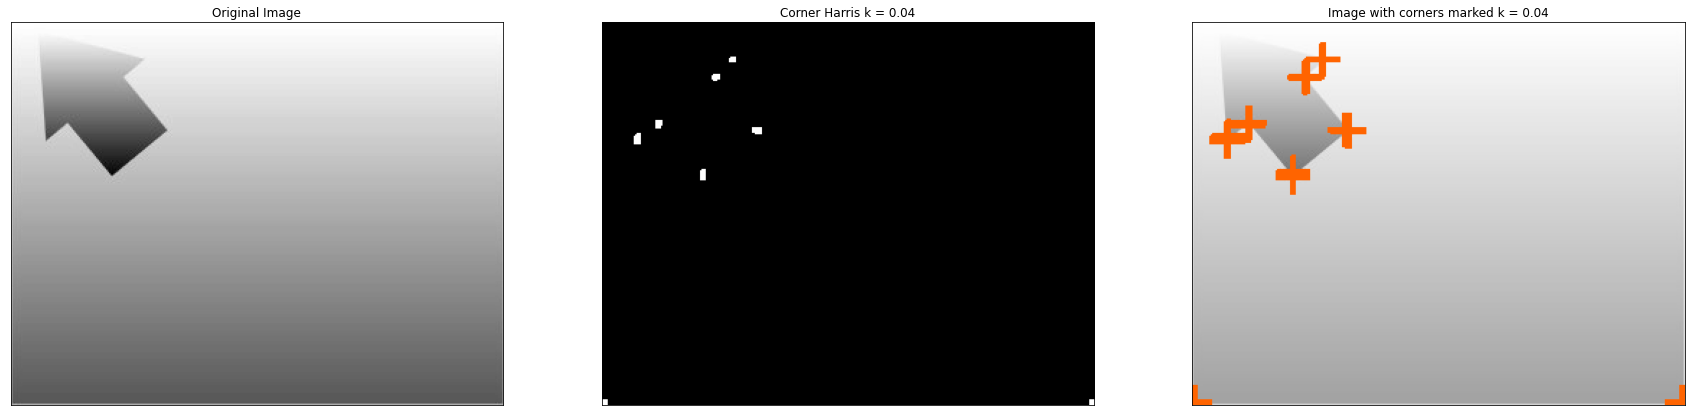

In [106]:
process_markers('images/chessboard.png')
process_markers('images/arrow_1.jpg')
process_markers('images/arrow_2.jpg')
process_markers('images/arrow_3.jpg')

### d) Increasing value of k
* As K decreases the algorithm becomes more sensitive to changing pixels, 
* As K increases the algorithm vanishes the image making it more difficult to find potential corners.

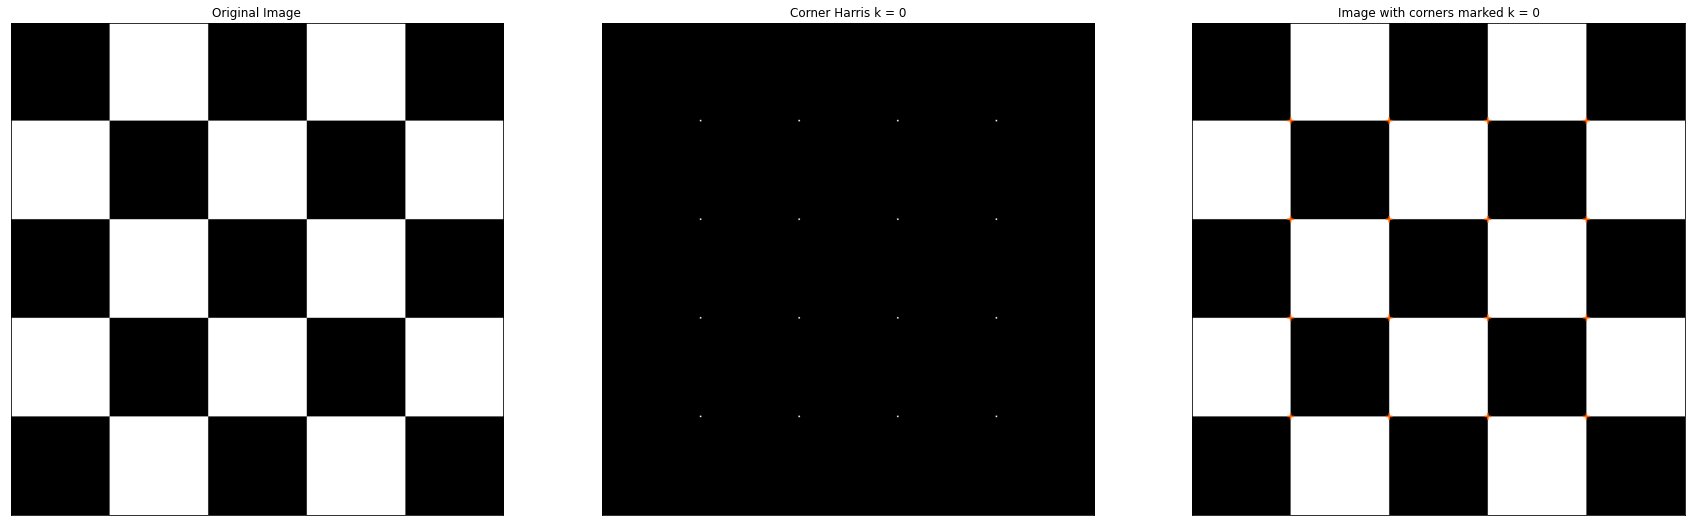

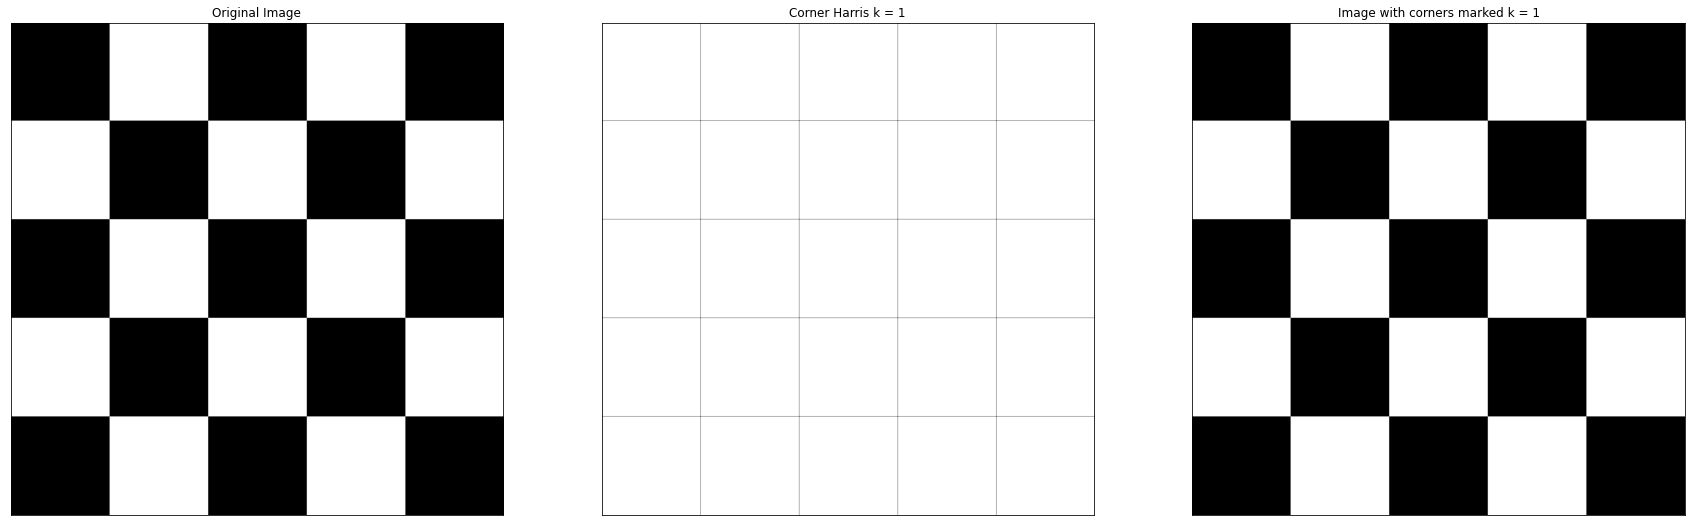

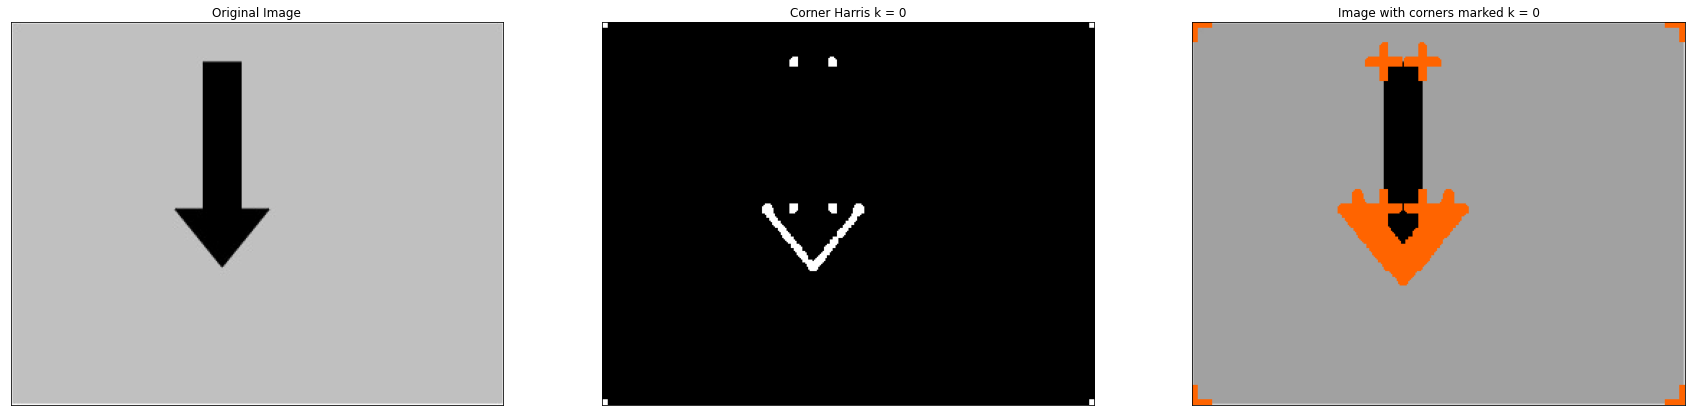

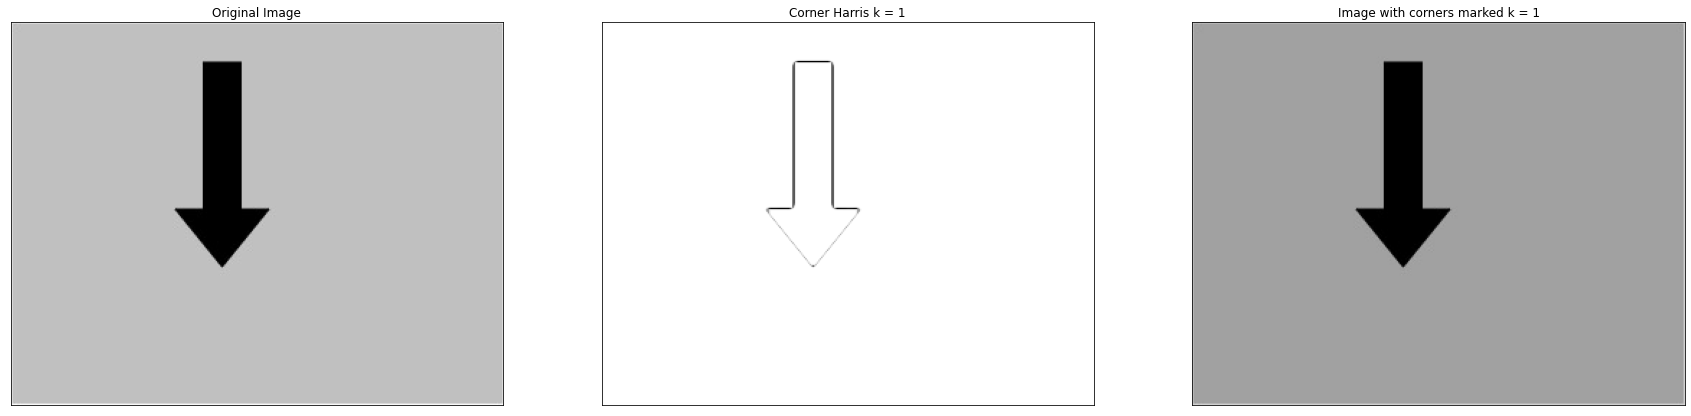

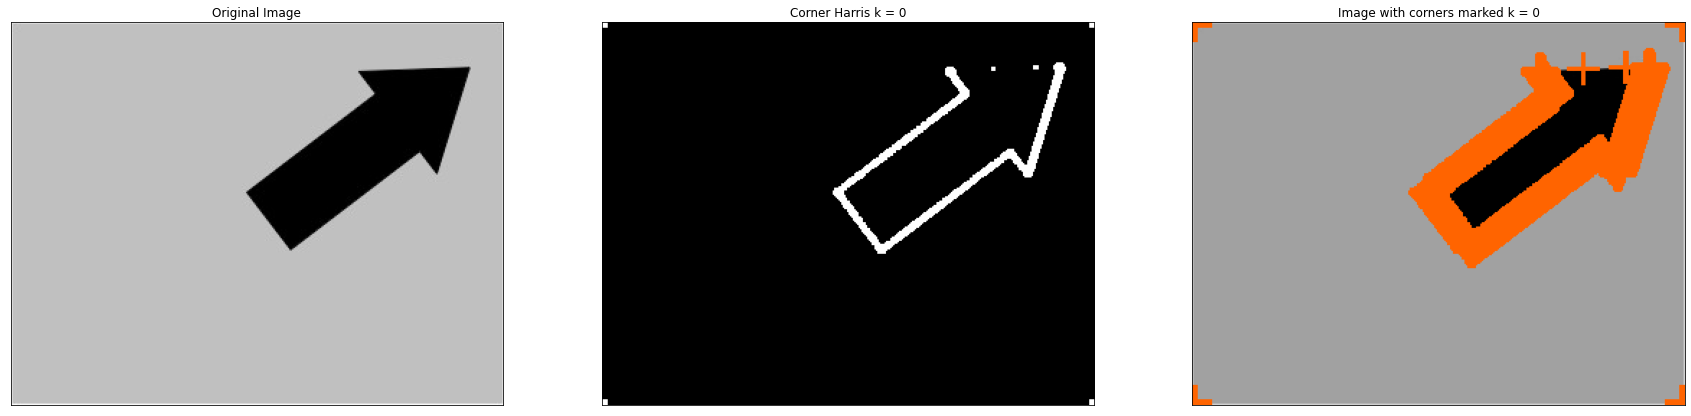

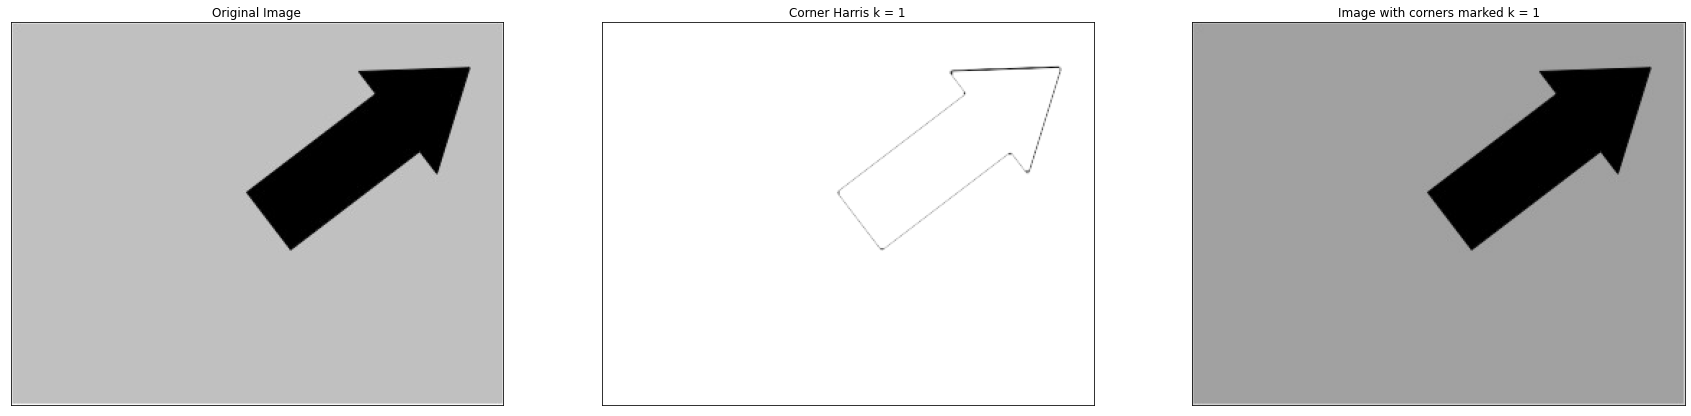

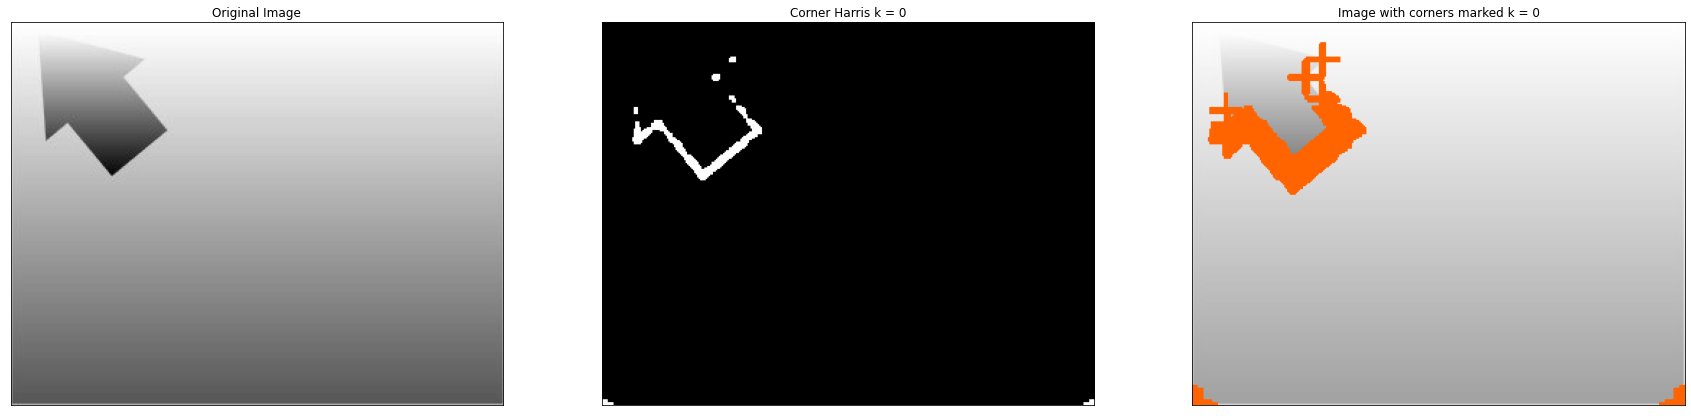

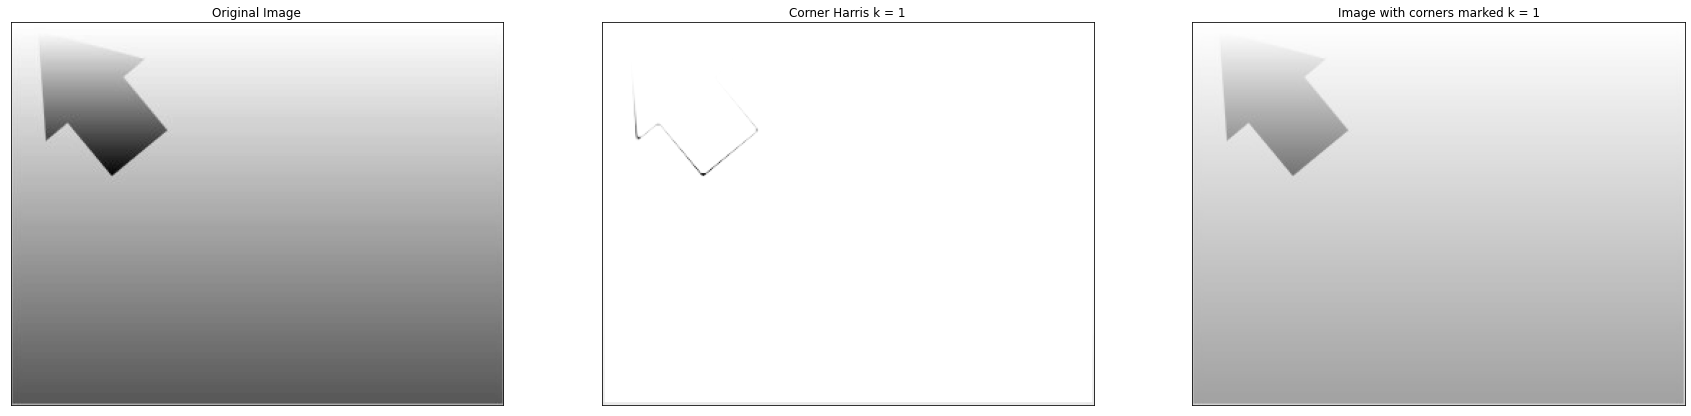

In [108]:
process_markers('images/chessboard.png',k=0)
process_markers('images/chessboard.png',k=1)
process_markers('images/arrow_1.jpg',k=0)
process_markers('images/arrow_1.jpg',k=1)
process_markers('images/arrow_2.jpg',k=0)
process_markers('images/arrow_2.jpg',k=1)
process_markers('images/arrow_3.jpg',k=0)
process_markers('images/arrow_3.jpg',k=1)

# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.

**b)** Why this approach is more popular than the Harris detector?

**c)** Explain the difference between a feature detector and a feature descriptor.

### a) SIFT Scale-Invariant Feature Transform
Is a feature detection algorithm used to detect features in image when being processed. 
1. Scale Space construction
    * An image pyramid is built. The image is processed through multiple Gaussian filters. The output of each filter is called a scale. 
    * The  algorithm moves on to the next octave by down-scale the image by a factor of 2 and produces another set of Gaussian blurred images. This process continues until the image size reach certain limit. The scale space contributes to the scale invariance of SIFT. 
2. Difference of Gaussian (DoG)
    * Images are taken from adjacent Gaussian-blurred images per octave.
    * For each octave, images of adjacent scales will subtract each other to create Difference of Gaussian (DoG) images. 
    * There will be Ox(S-1) number of DoG images in total.
3. Extreme point extraction
    * Keypoints are identified as local minima/maxima of the DoG images across scales. This is done by comparing each pixel in the DoG images to its eight neighbors at the same scale and nine corresponding neighboring pixels in each of the neighboring scales. If the pixel value is the maximum or minimum among all compared pixels, it is selected as a candidate keypoint.
4. Keypoint localization    
    * Extreme points extraction usually produces too many keypoint candidates. The following two kinds of candidates are eliminated:
    * Low-contrast keypoints
    * Edge responses
5. Orientation Assignment
    * Calculates orientation of each keypoint base on gradient. 
    * The magnitude and direction calculations for the gradient are done for every pixel in a neighboring window around the keypoint in the Gaussian-blurred image. 
    * Each pixel votes in a orientation histogram. In the provided reference implementation, the algorithm only picks the maximum orientation in the histogram as the orientation of a keypoint. 
    * More advanced implementations, e.g. sift++, lowe's sift, etc., consider all dominant orientations (>80% peak) as the orientations of a keypoint. In all these implementations, the orientation assignment is to ensure the keypoints are invariant to rotation.
    
    
### b) 
Harris detector is rotation invariant, but when scaling images it starts to underperform, therefore chosing SIFT is better.

### c) 
* Feature detector shows areas of the image throug processing algorithms where there is a specific feature to be observed.
* Feature descriptor usually is a dataset, vector or matrix that contains the representation and resolved values in the case study.


### Delivery (dead line) on CANVAS: 17.10.2021 at 23:59


## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Tomasetti Luca, room E-401
E-mail: luca.tomasetti@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.

In [ ]:
https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e